In [1]:
# Downlod the dataset
! rm -rf data
! rm *.csv*
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_custom.csv
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_custom.csv
! mkdir -p data
! mv *.csv data/


rm: cannot remove '*.csv*': No such file or directory
--2020-08-02 20:26:58--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_custom.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4111913 (3.9M) [text/csv]
Saving to: ‘test_custom.csv’

test_custom.csv     100%[===================>]   3.92M  --.-KB/s    in 0.03s   

2020-08-02 20:26:58 (136 MB/s) - ‘test_custom.csv’ saved [4111913/4111913]

--2020-08-02 20:27:00--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_custom.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 2

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D, MaxPooling1D
import matplotlib.pyplot as plt
import csv
import numpy as np
from tensorflow.keras.callbacks import Callback
import math
from tensorflow.keras.losses import categorical_crossentropy

In [3]:
class BatchGenerator:

    def __init__(self, data_path, batch_size):
        self.batch_size = batch_size
        self.data_path = data_path
        self.n_labels = 20

    def get_batch_gen(self, repeat=True):
        while True:
            with open(self.data_path) as data_file:
                reader = csv.reader(data_file)
                batch = []
                for row in reader:  # TODO: Can the next batch be fetched asynchronously? With asyncio?
                    batch.append(row)
                    if len(batch) >= self.batch_size:
                        batch = self._split_batch(batch)
                        yield batch
                        batch = []
                if 0 < len(batch) < self.batch_size:
                    yield self._split_batch(batch)
            if not repeat:
                break

    def _split_batch(self, batch):
        batch = np.array(batch, dtype=int)
        x = batch[:, :len(batch[0]) - self.n_labels]
        y = batch[:, len(batch[0]) - self.n_labels:]
        return x, y


class Metrics:
    def __init__(self):
        self.n_classes = 20

        self.losses = []
        self.accuracies = []
        self.f1macros = []

        self._epoch_loss = 0
        self._epoch_accuracy = 0
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

        self.n_batches = 0
        self.n_epochs = 0

    def record_batch(self, loss, yh, y):
        self.n_batches += 1
        self._epoch_loss += loss
        self._epoch_accuracy += self.find_accuracy(yh, y)
        self.confusion_matrix += self.get_confusion_matrix(yh, y, self.n_classes)

    def record_epoch(self):
        self.losses.append(self._epoch_loss / self.n_batches)
        self.accuracies.append(self._epoch_accuracy / self.n_batches)
        self.f1macros.append(self.get_f1_macro(self.confusion_matrix))

        self.n_epochs += 1
        self._epoch_loss = 0
        self._epoch_accuracy = 0
        self.n_batches = 0

    @staticmethod
    def get_f1_macro(confusion_matrix):
        n_classes = len(confusion_matrix)

        tp = np.zeros((n_classes,))
        fn = np.zeros((n_classes,))
        fp = np.zeros((n_classes,))

        for i_real in range(n_classes):
            for i_pred in range(n_classes):
                value = confusion_matrix[i_real][i_pred]
                if i_real == i_pred:
                    tp[i_real] = value
                else:
                    fn[i_real] += value
                    fp[i_pred] += value

        fn[fn == 0] = 1.e-06
        fp[fp == 0] = 1.e-06

        recall = tp / (tp + fn)
        precision = tp / (tp + fp)

        p_macro = sum(precision) / n_classes
        r_macro = sum(recall) / n_classes

        f_macro = 2 * p_macro * r_macro / (p_macro + r_macro)
        return f_macro

    @staticmethod
    def get_confusion_matrix(yh, y, n_classes):
        max_yh = yh.argmax(axis=1)
        max_y = y.argmax(axis=1)

        conf = np.zeros((n_classes, n_classes))
        for i in range(len(y)):
            conf[max_y[i]][max_yh[i]] += 1
        return conf

    @staticmethod
    def find_accuracy(y_hat, y_real):
        return sum(np.argmax(y_hat, axis=1) == np.argmax(y_real, axis=1)) / len(y_hat)


class MetricsCallback(Callback):
    def __init__(self, metrics_obj, data_gen, steps):
        super(MetricsCallback, self).__init__()
        self.metrics = metrics_obj
        self.data_gen = data_gen
        self.steps = steps

    def on_epoch_end(self, epoch, logs=None):
        for batch_i in range(math.ceil(self.steps)):
            x_batch, y_batch = next(self.data_gen)

            y_hat = self.model.predict(x_batch)

            loss = categorical_crossentropy(y_batch, y_hat)

            self.metrics.record_batch(float(sum(loss)), y_hat, y_batch)

        self.metrics.record_epoch()

        print(f"\tval_f1_macro: {self.metrics.f1macros[-1]}")


In [4]:
train_batch_size = 30
test_batch_size = 30
train_size = 11083
test_size = 7761
train_steps = train_size / train_batch_size
test_steps = test_size / test_batch_size

train_gen = BatchGenerator(data_path='data/train_custom.csv', batch_size=train_batch_size).get_batch_gen()
test_gen = BatchGenerator(data_path='data/test_custom.csv', batch_size=test_batch_size).get_batch_gen()
metrics = Metrics()

In [5]:
vocab_size = 10000
embed_size = 128

In [6]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embed_size, input_length=150),
    GlobalAveragePooling1D(),
    #LSTM(128, activation='relu'),
    #Bidirectional(LSTM(64, activation='relu')),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 1,299,092
Trainable params: 1,299,092
Non-trainable params: 0
______________________________________________

In [7]:
epochs = 25
history = model.fit(
    train_gen, steps_per_epoch=train_steps, epochs=epochs,
    validation_data=test_gen, validation_steps=test_steps, callbacks=[MetricsCallback(metrics, test_gen, test_steps)])

Epoch 1/25
370/369 [==============================] - 17s 46ms/step - loss: 2.6489 - accuracy: 0.1954 - val_loss: 2.3386 - val_accuracy: 0.3434
Epoch 2/25
370/369 [==============================] - 17s 45ms/step - loss: 1.5365 - accuracy: 0.5522 - val_loss: 1.4555 - val_accuracy: 0.5824
Epoch 3/25
370/369 [==============================] - 17s 46ms/step - loss: 0.8632 - accuracy: 0.7630 - val_loss: 1.0758 - val_accuracy: 0.6615
Epoch 4/25
370/369 [==============================] - 17s 46ms/step - loss: 0.5235 - accuracy: 0.8676 - val_loss: 0.8863 - val_accuracy: 0.7200
Epoch 5/25
370/369 [==============================] - 17s 46ms/step - loss: 0.3433 - accuracy: 0.9191 - val_loss: 0.8047 - val_accuracy: 0.7533
Epoch 6/25
370/369 [==============================] - 17s 46ms/step - loss: 0.2327 - accuracy: 0.9479 - val_loss: 0.7963 - val_accuracy: 0.7567
Epoch 7/25
370/369 [==============================] - 17s 46ms/step - loss: 0.1646 - accuracy: 0.9646 - val_loss: 0.7884 - val_accuracy:

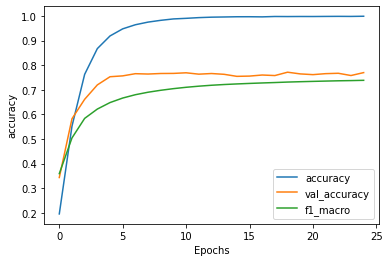

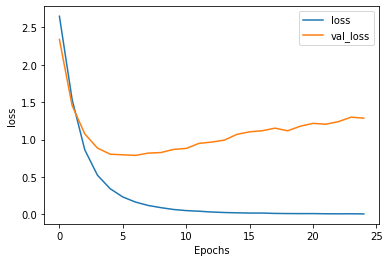

In [9]:
def plot_graphs(history, string, metrics=None):
    legend = [string, 'val_' + string]
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    if string == 'accuracy':
        plt.plot(metrics.f1macros)
        legend.append('f1_macro')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(legend)
    plt.show()

plot_graphs(history, "accuracy", metrics)
plot_graphs(history, "loss")


In [ ]:
model.save('linear.h5')

In [ ]:
#from google.colab import files
#files.download('linear.h5')